In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

2023-03-24 00:08:29.960252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 00:08:30.149092: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-24 00:08:30.751773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 00:08:30.751858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

# data preparation

In [2]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [3]:
def load_pk_file(file_name):
    with open(file_name, "rb") as f:
        return pickle.load(f)

data = load_pk_file('data_2.pickle')

In [4]:
# ---------- fill missing values with unknown ----------
data.fillna(
    {
    "movie_genre_2":"unknown", 
    'user_fav_genre': "unknown",
    'release_year': data.release_year.mean()
    }, 
    inplace=True
)

In [5]:
data.columns

Index(['userId', 'age', 'gender', 'occupation', 'zipcode_bucket', 'movieId',
       'imdb_id', 'title', 'movie_genre_1', 'movie_genre_2', 'IMDb_rating',
       'plot embedding', 'release_year', 'rating', 'user_avg_rating',
       'user_std_rating', 'user_rating_count', 'movie_avg_rating',
       'movie_std_rating', 'movie_rating_count', 'user_fav_genre',
       'user_fav_movieId', 'timestamp'],
      dtype='object')

In [10]:
# ---------- mormalized numerical columns ---------
numerical_cols = ['age', 'IMDb_rating', 'release_year', 'user_avg_rating', 'user_std_rating',  
                  'user_rating_count', 'movie_avg_rating', 'movie_std_rating', 'movie_rating_count',]

for col in numerical_cols:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())   

In [11]:
features = ['userId', 'age', 'gender', 'occupation', 'zipcode_bucket',                                     
            'movieId', 'movie_genre_1', 'movie_genre_2', 'IMDb_rating', 'plot embedding', 'release_year',   
            'rating', 'user_avg_rating', 'user_std_rating', 'user_rating_count', 'movie_avg_rating',        
            'movie_std_rating', 'movie_rating_count', 'user_fav_genre', 'user_fav_movieId', 'timestamp']

genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
              'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [12]:
# ---------- features and target ----------
X = data.drop(["rating", 'plot embedding', 'timestamp'] , axis = 1)
y = data['rating'].astype('float32')

In [13]:
raw_train = X[0:0]
raw_val = X[0:0]
raw_test = X[0:0]

In [14]:
# ---------- train/val/test split (80:10:10) by group of user and sort by timestamp ----------
for id, user_group in X.groupby('userId'):
    size = len(user_group)
    train_size, val_size = int(size * 0.8), int(size * 0.1)
    raw_train = pd.concat([raw_train, user_group[ : train_size]])
    raw_val = pd.concat([raw_val, user_group[train_size : train_size+val_size]])       
    raw_test = pd.concat([raw_test, user_group[train_size+val_size:]])

In [15]:
# ---------- tf dataset + shuffle + batch ----------
train_tfds = tf.data.Dataset.from_tensor_slices((dict(raw_train), y.iloc[raw_train.index])).shuffle(len(raw_train)).batch(32)
val_tfds = tf.data.Dataset.from_tensor_slices((dict(raw_val), y.iloc[raw_val.index])).shuffle(len(raw_val)).batch(32)
test_tfds = tf.data.Dataset.from_tensor_slices((dict(raw_test), y.iloc[raw_test.index])).shuffle(len(raw_test)).batch(32)

2023-03-24 00:23:56.238250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 00:23:56.238293: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 00:23:56.238330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-03-24 00:23:56.238719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
inputs = {
          # User 
          'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
          'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='int32'),
          'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
          'zipcode_bucket': tf.keras.layers.Input(name='zipcode_bucket', shape=(), dtype='string'),
    
          # Movie
          'movie_genre_1': tf.keras.layers.Input(name='movie_genre_1', shape=(), dtype='string'),
          'movie_genre_2': tf.keras.layers.Input(name='movie_genre_2', shape=(), dtype='string'),
          'IMDb_rating': tf.keras.layers.Input(name='IMDb_rating', shape=(), dtype='int32'),
          'release_year': tf.keras.layers.Input(name='release_year', shape=(), dtype='float32'),
    
          # user-movie
          'movieId': tf.keras.layers.Input(name='movieId', shape=(), dtype='int32'),
          'userId': tf.keras.layers.Input(name='userId', shape=(), dtype='int32'),
          'user_fav_genre': tf.keras.layers.Input(name='user_fav_genre', shape=(), dtype='string'),
          'user_fav_movieId': tf.keras.layers.Input(name='user_fav_movieId', shape=(), dtype='int32'),
    
          'user_avg_rating': tf.keras.layers.Input(name='user_avg_rating', shape=(), dtype='float32'),
          'user_std_rating': tf.keras.layers.Input(name='user_std_rating', shape=(), dtype='float32'),
          'user_rating_count': tf.keras.layers.Input(name='user_rating_count', shape=(), dtype='int32'),
    
          'movie_avg_rating': tf.keras.layers.Input(name='movie_avg_rating', shape=(), dtype='float32'),
          'movie_std_rating': tf.keras.layers.Input(name='movie_std_rating', shape=(), dtype='float32'),
          'movie_rating_count': tf.keras.layers.Input(name='movie_rating_count', shape=(), dtype='int32'),
}

In [17]:
# categorize, embed and indicate

# ---------- movieId ----------
movie_col = tf.feature_column.categorical_column_with_identity(key='movieId', num_buckets=1683)         
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
movie_ind_col = tf.feature_column.indicator_column(movie_col)

# ---------- userId ----------
user_col = tf.feature_column.categorical_column_with_identity(key='userId', num_buckets=944)
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
user_ind_col = tf.feature_column.indicator_column(user_col)

# ---------- occupation ----------
occupation_col = tf.feature_column.categorical_column_with_vocabulary_list(key="occupation", vocabulary_list=data['occupation'].unique())
occupation_emb_col = tf.feature_column.embedding_column(occupation_col, 4)

# ---------- gender ----------
gender_col = tf.feature_column.categorical_column_with_identity(key = 'gender', num_buckets= 2)
gender_ind_col = tf.feature_column.indicator_column(gender_col)

# ---------- zipcode_bucket ---------- 
zipcode_bucket_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'zipcode_bucket', vocabulary_list=data['zipcode_bucket'].unique())
zipcode_bucket_emb_col = tf.feature_column.embedding_column(zipcode_bucket_col, 10)

# ---------- movie_genre ---------- 
movie_genre_1_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'movie_genre_1', vocabulary_list=genre_cols)
movie_genre_2_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'movie_genre_2', vocabulary_list=genre_cols)
movie_genre_1_emd_col = tf.feature_column.embedding_column(movie_genre_1_col, 10)
movie_genre_2_emd_col = tf.feature_column.embedding_column(movie_genre_2_col, 10)
movie_genre_1_ind_col = tf.feature_column.indicator_column(movie_genre_1_col)

# ---------- user_fav_genre ---------- 
user_fav_genre_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'user_fav_genre', vocabulary_list=genre_cols)
user_fav_genre_emb_col = tf.feature_column.embedding_column(user_fav_genre_col, 10)
user_fav_genre_ind_col = tf.feature_column.indicator_column(user_fav_genre_col)

# ---------- user_fav_movieId ---------- 
user_fav_movieId_col = tf.feature_column.categorical_column_with_identity(key='user_fav_movieId', num_buckets=1683)     
user_fav_movieId_emb_col = tf.feature_column.embedding_column(user_fav_movieId_col, 10)



categorical_columns = [movie_emb_col, user_emb_col, occupation_emb_col, gender_ind_col, zipcode_bucket_emb_col,  
                       movie_genre_1_emd_col, movie_genre_2_emd_col, user_fav_genre_emb_col, user_fav_movieId_emb_col]

In [18]:
age_col = tf.feature_column.numeric_column('age')

IMDb_rating_col = tf.feature_column.numeric_column('IMDb_rating')
release_year_col = tf.feature_column.numeric_column('release_year')

user_avg_rating_col = tf.feature_column.numeric_column('user_avg_rating')
user_std_rating_col = tf.feature_column.numeric_column('user_std_rating')
user_rating_count_col = tf.feature_column.numeric_column('user_rating_count')

movie_avg_rating_col = tf.feature_column.numeric_column('movie_avg_rating')
movie_std_rating_col = tf.feature_column.numeric_column('movie_std_rating')
movie_rating_count_col = tf.feature_column.numeric_column('movie_rating_count')



numerical_columns = [age_col ,IMDb_rating_col , release_year_col, user_avg_rating_col , user_std_rating_col , user_rating_count_col ,
                     movie_avg_rating_col , movie_std_rating_col , movie_rating_count_col]

In [19]:
# ---------- plot train and val loss (rmse) ----------
def plot(history):
    rmse = history.history['loss']
    val_rmse = history.history['val_loss']
    epochs = range(len(rmse))

    plt.title('Training and validation rmse')
    plt.plot(epochs, rmse, color='blue', label='Train')
    plt.plot(epochs, val_rmse, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('rmse')
    plt.legend()

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=8,
    mode='auto',
    restore_best_weights=True
)

# models

## NeuralCF

In [22]:
# ---------- concatenate userId embedding and movieId embedding ----------
mlp = tf.keras.layers.concatenate([tf.keras.layers.DenseFeatures([movie_emb_col])(inputs), tf.keras.layers.DenseFeatures([user_emb_col])(inputs)])
mlp = tf.keras.layers.Dense(64, activation='relu')(mlp)
mlp = tf.keras.layers.Dense(32, activation='relu')(mlp)
neuralCF_output_layer = tf.keras.layers.Dense(1)(mlp)
neuralCF_model = tf.keras.Model(inputs, neuralCF_output_layer)

In [23]:
neuralCF_model.compile(
    loss=rmse,
    optimizer='adam'
)

neuralCF_history = neuralCF_model.fit(
    train_tfds,
    validation_data = val_tfds, 
    callbacks=[early_stopping],
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['imdb_id', 'title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2487/2487 [==============================] - 12s 4ms/step - loss: 1.0638 - val_loss: 1.0236
Epoch 2/50
2487/2487 [==============================] - 12s 4ms/step - loss: 0.9388 - val_loss: 0.9807
Epoch 3/50
2487/2487 [==============================] - 11s 4ms/step - loss: 0.9199 - val_loss: 0.9777
Epoch 4/50
2487/2487 [==============================] - 11s 4ms/step - loss: 0.9106 - val_loss: 0.9816
Epoch 5/50
2487/2487 [==============================] - 12s 4ms/step - loss: 0.9039 - val_loss: 0.9705
Epoch 6/50
2487/2487 [==============================] - 13s 4ms/step - loss: 0.8965 - val_loss: 0.9761
Epoch 7/50
2487/2487 [==============================] - 11s 4ms/step - loss: 0.8898 - val_loss: 0.9713
Epoch 8/50
2487/2487 [==============================] - 12s 4ms/step - loss: 0.8841 - val_loss: 0.9689
Epoch 9/50
2487/2487 [==============================] - 12s 5ms/step - loss: 0.8775 - val_loss: 0.9694
Epoch 10/50
2487/2487 [==============================] - 12s 4ms/step - loss: 0.8698

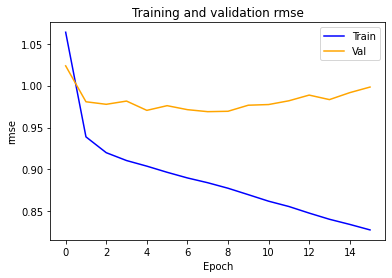

In [24]:
plot(neuralCF_history)

## DeepFM

In [25]:

# factorized machine order 1 interection / linear regression 
fm_first_order_cols = [movie_ind_col, user_ind_col, movie_genre_1_ind_col,user_fav_genre_ind_col]
fm_first_order_layer = tf.keras.layers.DenseFeatures(fm_first_order_cols)(inputs)

# factorized machine order 2 interection, embedding dot product between features
movie_emb_layer = tf.keras.layers.DenseFeatures([movie_emb_col])(inputs)
user_emb_layer = tf.keras.layers.DenseFeatures([user_emb_col])(inputs)
movie_genre_emb_layer = tf.keras.layers.DenseFeatures([movie_genre_1_emd_col])(inputs)
user_genre_emb_layer = tf.keras.layers.DenseFeatures([user_fav_genre_emb_col])(inputs)

# embedding dot product between features
product_layer_movie_user = tf.keras.layers.Dot(axes=1)([movie_emb_layer, user_emb_layer])
product_layer_movie_genre_user_genre = tf.keras.layers.Dot(axes=1)([movie_genre_emb_layer, user_genre_emb_layer])
product_layer_movie_genre_user = tf.keras.layers.Dot(axes=1)([movie_genre_emb_layer, user_emb_layer])
product_layer_user_genre_movie = tf.keras.layers.Dot(axes=1)([user_genre_emb_layer, movie_emb_layer])

# deep part of this model is exactly the same as that in wide and deep model
deepfm_deep = tf.keras.layers.DenseFeatures(numerical_columns + categorical_columns)(inputs)
deepfm_deep = tf.keras.layers.Dense(256, activation='relu')(deepfm_deep)
deepfm_deep = tf.keras.layers.Dense(128, activation='relu')(deepfm_deep)


deepfm_concat_layer = tf.keras.layers.concatenate(
    [
    fm_first_order_layer, 
    product_layer_movie_user, 
    product_layer_movie_genre_user_genre,
    product_layer_movie_genre_user,
    product_layer_user_genre_movie,
    deepfm_deep
    ],
    axis=1
)
deepfm_output_layer = tf.keras.layers.Dense(1)(deepfm_concat_layer)
deepfm_model = tf.keras.Model(inputs, deepfm_output_layer)

In [26]:
deepfm_model.compile(
    loss=rmse,
    optimizer='adam'
)

deepfm_history = deepfm_model.fit(
    train_tfds,
    validation_data = val_tfds, 
    callbacks = [early_stopping],
    epochs = 50
)

Epoch 1/50
2487/2487 [==============================] - 21s 7ms/step - loss: 0.9292 - val_loss: 0.9213
Epoch 2/50
2487/2487 [==============================] - 18s 7ms/step - loss: 0.8665 - val_loss: 0.9266
Epoch 3/50
2487/2487 [==============================] - 19s 7ms/step - loss: 0.8401 - val_loss: 0.9142
Epoch 4/50
2487/2487 [==============================] - 17s 7ms/step - loss: 0.8093 - val_loss: 0.9162
Epoch 5/50
2487/2487 [==============================] - 18s 7ms/step - loss: 0.7782 - val_loss: 0.9225
Epoch 6/50
2487/2487 [==============================] - 18s 7ms/step - loss: 0.7480 - val_loss: 0.9309
Epoch 7/50
2487/2487 [==============================] - 19s 7ms/step - loss: 0.7196 - val_loss: 0.9405
Epoch 8/50
2487/2487 [==============================] - 18s 7ms/step - loss: 0.6941 - val_loss: 0.9597
Epoch 9/50
2487/2487 [==============================] - 18s 7ms/step - loss: 0.6703 - val_loss: 0.9744
Epoch 10/50
2487/2487 [==============================] - 19s 7ms/step - l

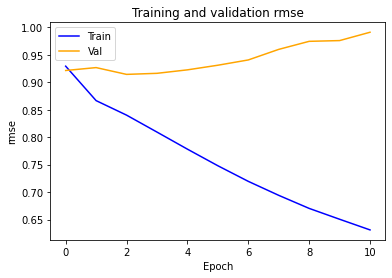

In [27]:
plot(deepfm_history)

## result

In [28]:
result_df_neuralCF = pd.DataFrame.from_dict(neuralCF_model.evaluate(test_tfds, return_dict = True), orient='index',columns = ["neuralCF"]).transpose()
result_df_deepfm = pd.DataFrame.from_dict(deepfm_model.evaluate(test_tfds, return_dict = True), orient='index',columns = ["deepfm"]).transpose()

result_df = pd.concat([result_df_neuralCF, result_df_deepfm])
result_df.columns = ['test loss (rmse)']
result_df

337/337 [==============================] - 2s 4ms/step - loss: 0.9589


,test loss (rmse)
neuralCF,1.009781
deepfm,0.958909


In [29]:
neuralCF_model.save('neuralCF', include_optimizer=False)
deepfm_model.save('deepfm',include_optimizer=False)

INFO:tensorflow:Assets written to: neuralCF/assets


INFO:tensorflow:Assets written to: neuralCF/assets


INFO:tensorflow:Assets written to: deepfm/assets


INFO:tensorflow:Assets written to: deepfm/assets
